In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
from scipy.optimize import differential_evolution

Для лабораторной работы был выбран набор данных, собранный на двух солнечных электростанциях в Индии в течение 34 дней

https://www.kaggle.com/datasets/anikannal/solar-power-generation-data/data

In [2]:
data = pd.read_csv('../data/Plant_1_Generation_Data.csv', parse_dates=['DATE_TIME'], dayfirst=True)
data.set_index('DATE_TIME', inplace=True)

In [3]:
data.head()

,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
DATE_TIME,,,,,,
2020-05-15,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
2020-05-15,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2020-05-15,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
2020-05-15,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
2020-05-15,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


In [4]:
data.describe()

,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
count,68778.0,68778.000000,68778.000000,68778.000000,6.877800e+04
mean,4135001.0,3147.426211,307.802752,3295.968737,6.978712e+06
std,0.0,4036.457169,394.396439,3145.178309,4.162720e+05
min,4135001.0,0.000000,0.000000,0.000000,6.183645e+06
25%,4135001.0,0.000000,0.000000,0.000000,6.512003e+06
50%,4135001.0,429.000000,41.493750,2658.714286,7.146685e+06
75%,4135001.0,6366.964286,623.618750,6274.000000,7.268706e+06
max,4135001.0,14471.125000,1410.950000,9163.000000,7.846821e+06


In [5]:
hourly_data = data[['DC_POWER']].resample('h').mean()

In [6]:
hourly_data.head(24)

,DC_POWER
DATE_TIME,
2020-05-15 00:00:00,0.000000
2020-05-15 01:00:00,0.000000
2020-05-15 02:00:00,0.000000
2020-05-15 03:00:00,0.000000
2020-05-15 04:00:00,0.000000
2020-05-15 05:00:00,0.000000
2020-05-15 06:00:00,592.813884
2020-05-15 07:00:00,1976.423945
2020-05-15 08:00:00,4220.533983


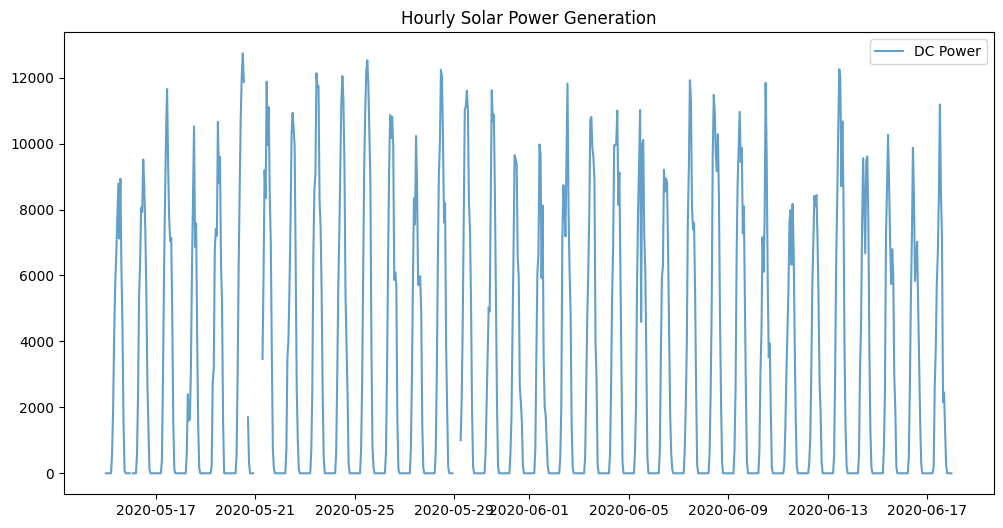

In [7]:
# Визуализация 'DC_POWER' по часам
plt.figure(figsize=(12, 6))
plt.plot(hourly_data['DC_POWER'], label='DC Power', alpha=0.7)
plt.title('Hourly Solar Power Generation')
plt.legend()
plt.show()

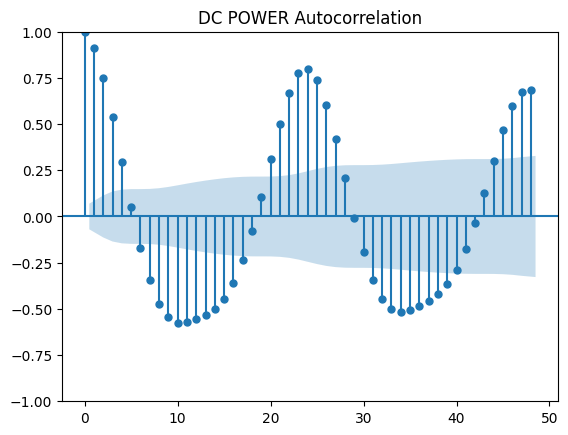

In [8]:
# Построение автокорреляции для 'DC_POWER'
plot_acf(hourly_data['DC_POWER'].dropna(), lags=48)
plt.title('DC POWER Autocorrelation')
plt.show()

Сезонность составляет 24 часа.
Всего периодов 34.

In [9]:
# Разделение на тренировочный и тестовый наборы
train_data = hourly_data[:-48]['DC_POWER'].dropna()
test_data = hourly_data[-48:]['DC_POWER'].dropna()

In [10]:
def holt_winters(series, alpha, beta, gamma, season_length, n_preds=1):
    result = []
    # Инициализация: начальный уровень, тренд и сезонные компоненты
    level = series[0]
    trend = series[1] - series[0]
    seasonals = [series[i] - level for i in range(season_length)]

    for i in range(len(series) + n_preds):
        if i >= len(series):  # Прогноз
            m = i - len(series) + 1
            result.append(level + m * trend + seasonals[i % season_length])
        else:
            value = series[i]
            last_level = level
            last_trend = trend

            
            level = alpha * (value - seasonals[i % season_length]) + (1 - alpha) * (last_level + last_trend)
            trend = beta * (level - last_level) + (1 - beta) * last_trend
            seasonals[i % season_length] = gamma * (value - level) + (1 - gamma) * seasonals[i % season_length]
                
            result.append(level + trend + seasonals[i % season_length])

    return result, level, trend, seasonals

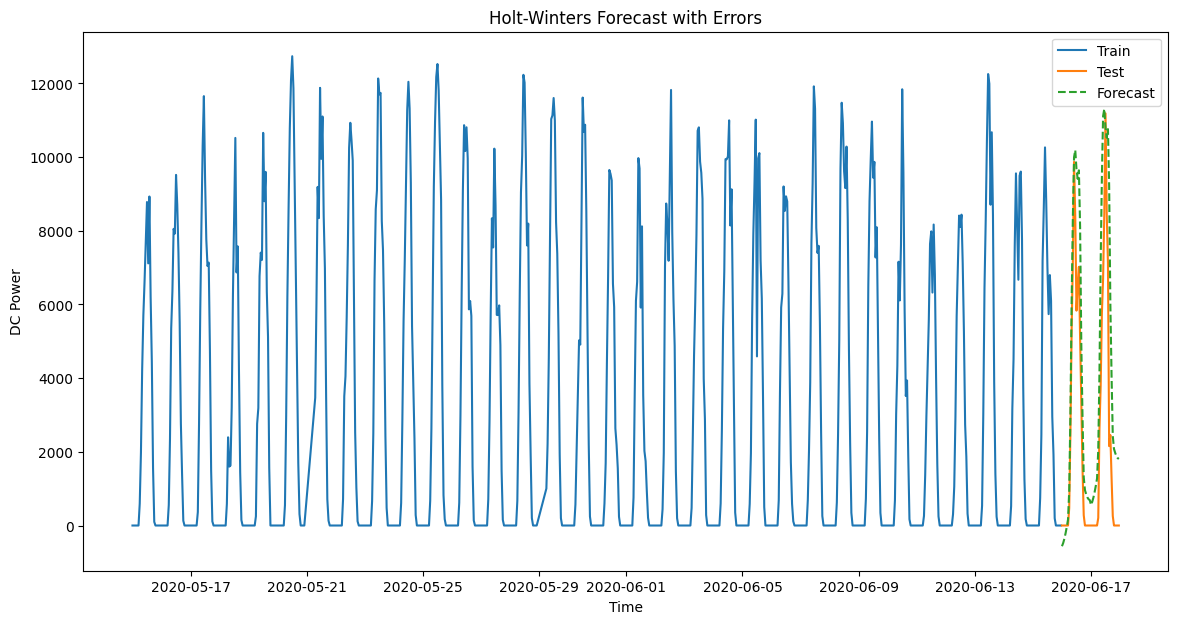

,Horizon,RMSE
0,1,2179.499789
1,2,2656.192975


In [11]:
# Применение модели
alpha, beta, gamma = 0.2, 0.1, 0.3
season_length = 24  # Длина сезона
n_preds = 48
result, level, trend, seasonals = holt_winters(train_data.values, alpha, beta, gamma, season_length, n_preds)

horizons = [1, 2]
errors = []

for h in horizons:
    forecast_h = result[-n_preds:][:len(test_data) - (h - 1)]
    actual_h = test_data.values[h - 1:]
    rmse = np.sqrt(mean_squared_error(actual_h, forecast_h))
    
    errors.append({
        "Horizon": h,
        "RMSE": rmse
    })

error_df = pd.DataFrame(errors)

# Построение графиков прогнозов и ошибок
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data.values, label='Train')
plt.plot(test_data.index, test_data.values, label='Test')
plt.plot(test_data.index, result[-n_preds:], label='Forecast', linestyle='--')
plt.title('Holt-Winters Forecast with Errors')
plt.xlabel('Time')
plt.ylabel('DC Power')
plt.legend()
plt.show()
error_df


In [12]:
# Реализация модели Хольта-Уинтерса с тюнингом
def holt_winters(series, alpha, beta, gamma, season_length, n_preds=1):
    result = []
    seasonals = [series[i] - series[:season_length].mean() for i in range(season_length)]
    level = series[0]
    trend = series[1] - series[0]
    for i in range(len(series) + n_preds):
        if i >= len(series):  # Прогноз
            m = i - len(series) + 1
            result.append(level + m * trend + seasonals[i % season_length])
        else:
            value = series[i]
            last_level = level
            last_trend = trend
            level = alpha * (value - seasonals[i % season_length]) + (1 - alpha) * (last_level + last_trend)
            trend = beta * (level - last_level) + (1 - beta) * last_trend
            seasonals[i % season_length] = gamma * (value - level) + (1 - gamma) * seasonals[i % season_length]
            result.append(level + trend + seasonals[i % season_length])

    return result[-n_preds:]  # Возвращаем только прогноз

# Функция для оптимизации
def optimize_hw(params, series, test_series):
    alpha, beta, gamma, season_length = params
    season_length = int(season_length)  # Длина сезона должна быть целым числом
    forecast = holt_winters(series, alpha, beta, gamma, season_length, len(test_series))
    return np.sqrt(mean_squared_error(test_series, forecast))

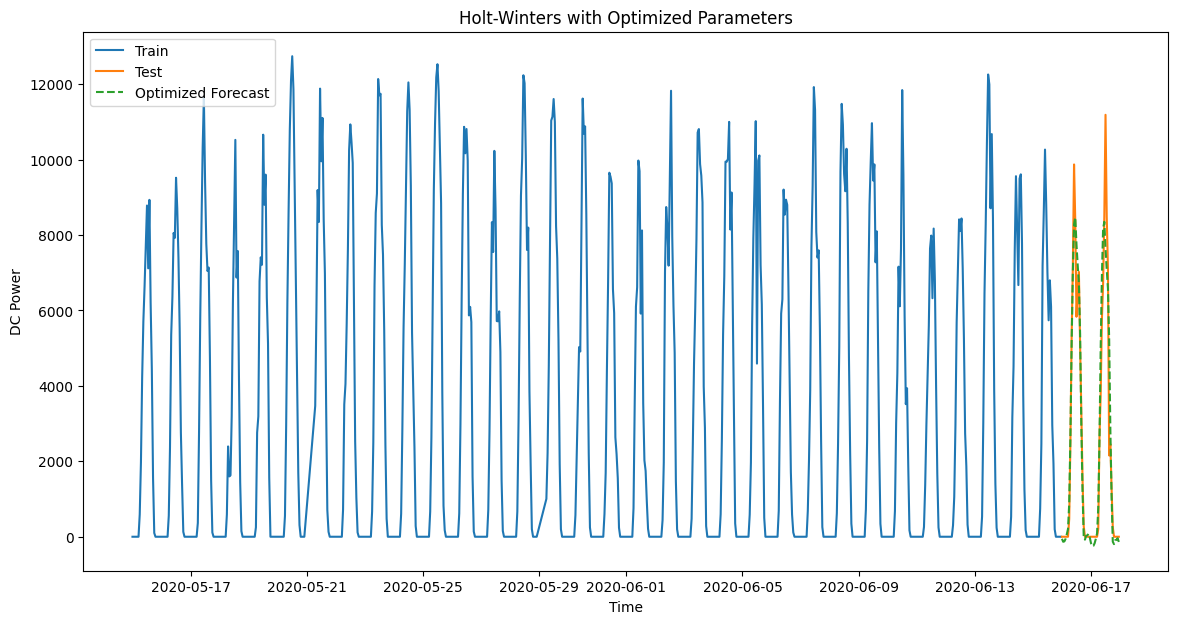

In [13]:
initial_params = [0.1, 0.1, 0.1, 1]
bounds = [(0, 1), (0, 1), (0, 1), (1, 48)]
opt_result = differential_evolution(
    func=lambda params: optimize_hw(params, train_data.values, test_data.values),
    bounds=bounds,
    strategy='best1bin',
    maxiter=100,
    popsize=15,
    tol=0.01,
    seed=42
)

opt_params = opt_result.x
alpha_opt, beta_opt, gamma_opt, season_length_opt = opt_params
season_length_opt = int(season_length_opt)
optimized_forecast = holt_winters(train_data.values, 
                                  alpha_opt, 
                                  beta_opt, 
                                  gamma_opt, 
                                  season_length_opt, 
                                  len(test_data))

# Построение графика
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data.values, label='Train')
plt.plot(test_data.index, test_data.values, label='Test')
plt.plot(test_data.index, optimized_forecast, label='Optimized Forecast', linestyle='--')
plt.title('Holt-Winters with Optimized Parameters')
plt.xlabel('Time')
plt.ylabel('DC Power')
plt.legend()
plt.show()

In [14]:
alpha, beta, gamma = 0.2, 0.1, 0.3
result_no_tuning = holt_winters(train_data.values, alpha, beta, gamma, season_length, len(test_data))
rmse_no_tuning = np.sqrt(mean_squared_error(test_data.values, result_no_tuning))

error_df = pd.DataFrame({
    "Model": ["Without Tuning", "With Tuning"],
    "Alpha": [alpha, opt_params[0]],
    "Beta": [beta, opt_params[1]],
    "Gamma": [gamma, opt_params[2]],
    "Season Length": [season_length, season_length_opt],
    "RMSE": [rmse_no_tuning, np.sqrt(mean_squared_error(test_data.values, optimized_forecast))]

})

error_df

,Model,Alpha,Beta,Gamma,Season Length,RMSE
0,Without Tuning,0.200000,0.100000,0.300000,24,2173.074585
1,With Tuning,0.141937,0.017337,0.134506,24,887.221554
